# LAYERS
# 1st Approach - INFLEXION POINTS

In our first approach, we determine the layers according to the inflexion points of the salinity vertical profiles. Inflexion points are those points where the profile form changes from concave to convex, or vice versa. These points are situated where the second derivative is equal to zero.

In [1]:
#Code of the first approach to determine the layers of a vertical profile - zpau - 03/02/2022
#First, some imports
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotting_functions as plot

#Now we read the data
from read_CTD import read_CTD
data_dirs = ['C:/Users/Pau/Data/TFM/CTD_proc_files_1mbin/']
data=read_CTD(data_dirs)

#And delete the outliers
from out_outliers import out_outliers
for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)

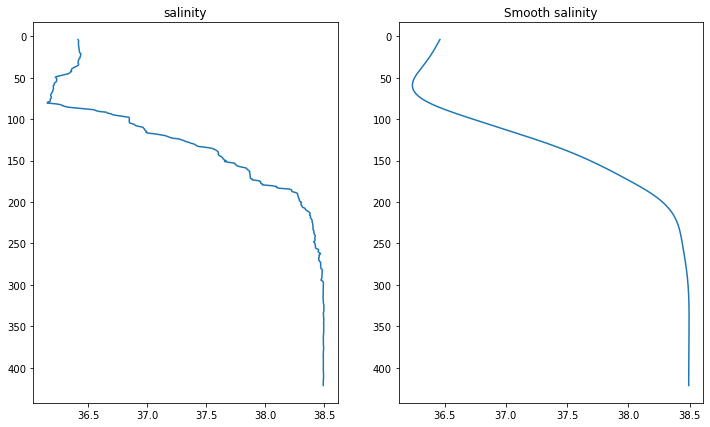

In [5]:
#We will work with the example of the salinity vertical profile number ncast='09'
ncast = '09'
#Smooth the profile
#To smooth the profile, we use a filter that extracts its tendency (this filter is usually used for time series but works well with our profiles)
variable = 'salinity'
lamb = 50000         #Smooth exageration
var_cicle, var_tend = sm.tsa.filters.hpfilter(data[ncast][variable],lamb=lamb)

#Now we plot the vertical profile and its smooth version
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,7))
ax0.plot(data[ncast][variable], var_tend.index)
ax0.invert_yaxis()
ax0.set_title(variable)
ax0.set_yticks(np.arange(0, max(var_tend.index), 50))
ax1.plot(var_tend, var_tend.index)
ax1.invert_yaxis()
ax1.set_title('Smooth '+variable)
ax1.set_yticks(np.arange(0, max(var_tend.index), 50))
plt.show()

Qualitatively, in the big scale, we could destinguish 3 zones, (1) the superficial zone, (2) the halocline and (3) a lower zone more homogeneus

Thus, we should detect one inflexion point approximately in the middle of the halocline

If we analyse it from a smaller scale perspective, we also coud distinguix another inflexion point at the shallower zone (around 50m)

The detection of those inflexion points of a smaller scale will depend on the smooth exageration

Summing up, we would expect to detect 2 or 3 layers. A shallow one (0 to 50m) and two separated by the halocline. Let's see how many layers this approach detects.

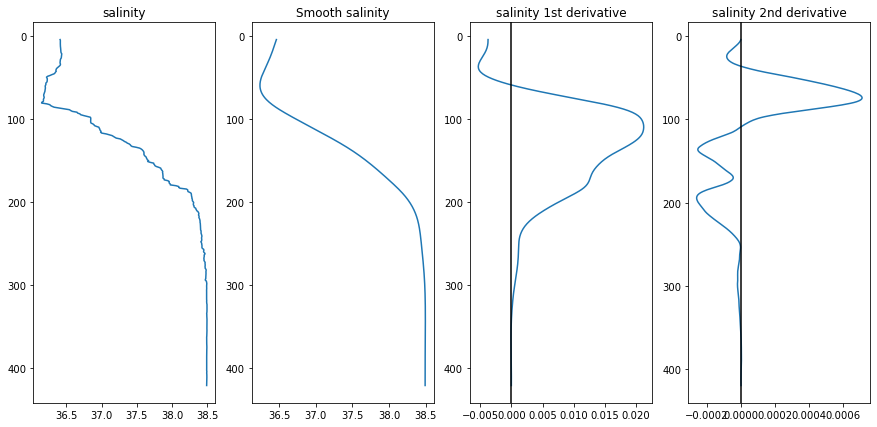

In [6]:
#Calculate the 1st and 2nd derivative
der1_var_tend = np.diff(var_tend, n=1)
der2_var_tend = np.diff(var_tend, n=2)

#Plot the vertical profiles and its derivatives
fig0, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(15,7))
ax0.plot(data[ncast][variable], var_tend.index)
ax0.invert_yaxis()
ax0.set_title(variable)
ax1.plot(var_tend, var_tend.index)
ax1.invert_yaxis()
ax1.set_title('Smooth '+variable)
ax2.plot(der1_var_tend, var_tend.index[:-1])
ax2.invert_yaxis()
ax2.axvline(x=0, c='black')
ax2.set_title(variable+' 1st derivative')
ax3.plot(der2_var_tend, var_tend.index[:-2])
ax3.invert_yaxis()
ax3.axvline(x=0, c='black')
ax3.set_title(variable+' 2nd derivative')
plt.show()

Profile 09 has 5 layers


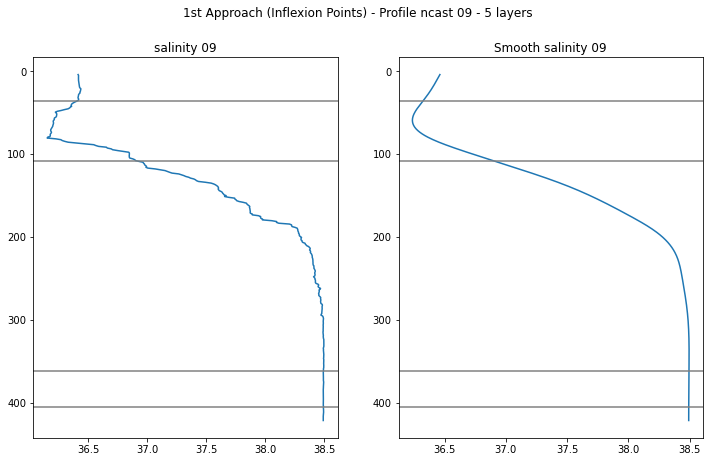

In [7]:
#Now let's find the indexs where the inflexion points are
ind_inflexion=[]
list_ind = []
for i in range(len(der2_var_tend)):
    if i == (len(der2_var_tend)-1):
        break
    elif (der2_var_tend[i] * der2_var_tend[i+1]) < 0:
        ind_inflexion.append(i)
        ind_inflexion.append(i+1)
        list_ind.append(ind_inflexion)
        ind_inflexion = []
        
#Now let's find the depth of these inflexion points
pres_inflexion = []
for i in list_ind:
    pres = (data[ncast].index[i[0]] + data[ncast].index[i[1]])/2  
    pres_inflexion.append(pres)

nlayers = len(pres_inflexion) + 1
print('Profile '+ncast+' has '+str(nlayers)+' layers')

#Now we plot the result of the profile with its inflexion points
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,7))
fig.suptitle('1st Approach (Inflexion Points) - Profile ncast '+ncast+' - '+str(nlayers)+' layers')
ax0.plot(data[ncast][variable], data[ncast].index)
ax0.invert_yaxis()
for i in pres_inflexion:
    ax0.axhline(y=i, c='grey')
ax0.set_title(variable+' '+ncast)
ax1.plot(var_tend, data[ncast].index)
ax1.invert_yaxis()
for i in pres_inflexion:
    ax1.axhline(y=i, c='grey')
ax1.set_title('Smooth '+variable+' '+ncast)
#plt.savefig('layers_'+ncast+'_1stApproach.png')
plt.show()

The approach detects well the 2 inflexion points that we expected in the qualitatively analysis but it detects two extra inflexion points at the lower zone. Thus, it classifies the profile with 5 layers when we expected 2 or 3.

Testing this approach with other profiles we observed that the main problem of the approach is that it detects too many layers in some profiles. If  we make the profiles smoother (lamb=5000000), it does not detect the subtlest layers but it detects better the gran scale features, which is what we want. However, it keeps detecting too many layers in some vertical profiles so we will try another approach and see which one fits better.

We can see, with the same example (ncast='09') that if we make the profile more smooth, this approach makes more coherent results:

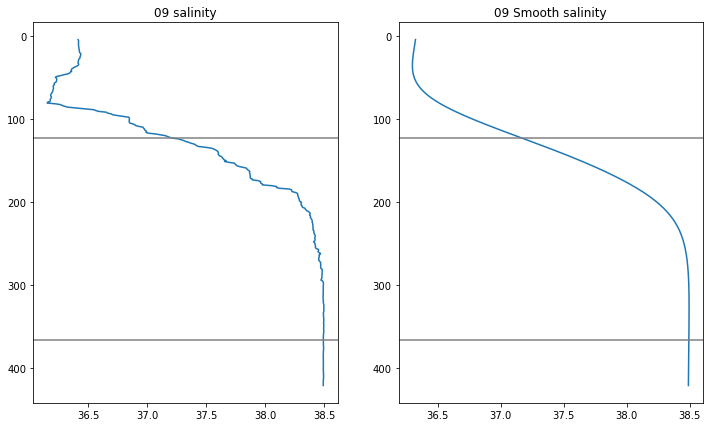

3

In [10]:
from inflexion_points import inflexion_points_plot
ncast = '09'
inflexion_points_plot(data, ncast, 'salinity', lamb=500000)

Let's see some examples of the difference of make the profile more or less smooth:

exageration lamb=500000


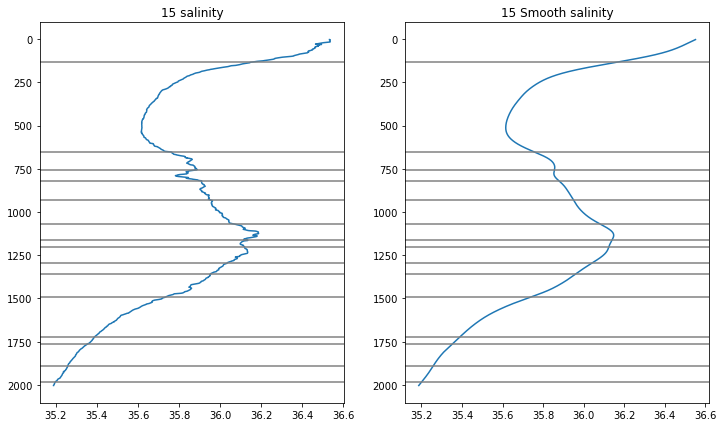


exageration lamb=5000000


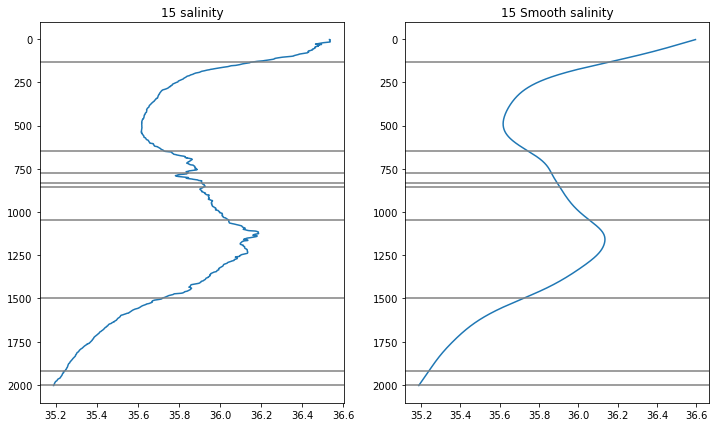


exageration lamb=50000000


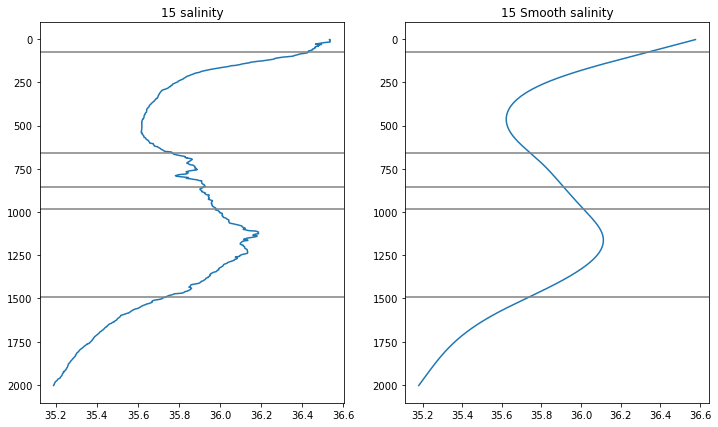

6

In [6]:
#To see the difference between different exagerations of the profile smoothing
from inflexion_points import inflexion_points_plot
ncast='15'
variable='salinity'
print('exageration lamb=500000')
inflexion_points_plot(data, ncast, variable, lamb=500000)
print()
print('exageration lamb=5000000')
inflexion_points_plot(data, ncast, variable, lamb=5000000)
print()
print('exageration lamb=50000000')
inflexion_points_plot(data, ncast, variable, lamb=50000000)

Maybe we could use this first approach with a version that exagerates the smooth a lot, for example lamb=50000000 

The file 'inflexion_points.py' has two functions. 

'inflexion_points' is a function that resumes this approach and returns the number of layers of the profile. 

'inflexion_points_plot' is a function that resumes this approach and shows the plotting results.